### Initial Modeling

Like what I've remarked before, not that I will 'recycle' this code for running subsequent versions of data.
I would still like to make a second and fancier version of this project, and likely that would be in its own
notebook, but for now:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ss

In [2]:
from nltk.corpus import stopwords
import regex as re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import warnings #Idea from Ben Moss of our GA cohort - thank you! Just to make tuning easier on our eyes...
warnings.simplefilter(action='ignore', category=FutureWarning);

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('data/cleaned_reddits.csv') #Importing our cleanned data. See the EDA notebook for 
#details how we got here.

In [4]:
X = df['cleaned_post']
y = df['subreddit']

In [5]:
#Let's go ahead and make our train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, #Perhaps subject to change, but we'll go with it for now
                                                    random_state = 26, #Recall that I like this number
                                                    stratify=y)

In [6]:
#Potentially not the most relevant here, but I'd like to get a taste of common words before any additional steps are taken.
cvec_ex = CountVectorizer(stop_words='english') #We'll at least get rid of English stopwords
X_train_cvec_ex = cvec_ex.fit_transform(X_train)

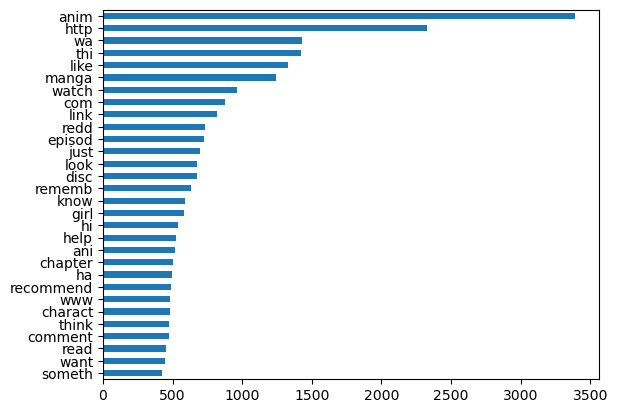

In [7]:
X_train_ex = pd.DataFrame(X_train_cvec_ex.todense(),
                          columns=cvec_ex.get_feature_names_out())

X_train_ex.sum().sort_values().tail(30).plot(kind="barh");

In [8]:
#So, a number are not surprising. Most importantly are the two subreddits themselvs, representing each other's medium.
#To show the folloiwng before continuing to comment:
print('anim')
print(df[df['cleaned_post'].str.contains('anim')]['subreddit'].value_counts(normalize=True))
print('~'*26)
print('manga')
print(df[df['cleaned_post'].str.contains('manga')]['subreddit'].value_counts(normalize=True))

#I would like to clarify that I'm gauging frequency in just the raw occurence of a word as opposed to word count, as
#I'm interested in seeing just the raw presence of one word over another in any post, let alone its scale, to try to gauge
#the presence or lack there of, of words.

anim
subreddit
1    0.941046
0    0.058954
Name: proportion, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~
manga
subreddit
0    0.863132
1    0.136868
Name: proportion, dtype: float64


In [9]:
#Of special note to comment off the bat are 'tier2' indicator words such as 'watch' and 'episod' that are directly
#related to one form over the other. Afterwards, other words denotatively should not be inclined in either direction,
#howeve, we clearly see many, such as 'http' being not only quite frequent, but in one direction too:
print('http')
print(df[df['cleaned_post'].str.contains('http')]['subreddit'].value_counts(normalize=True))
#And at this point I beckon the reader to recall our observation of the discrepencies between manga and anime
#cleaned word count...

http
subreddit
1    0.78853
0    0.21147
Name: proportion, dtype: float64


In [10]:
#So, let's get to it. Unless we think of something else, then we have the following combinations of 'processes' to consider:
#1) 2 options for our vectorizers: CountVectorizer, and Tf_IdfVectorizer (TIffany per the nicknake I'm giving her)
#2) Modeling via Logistic Regression, Multinomial NB, Support Vector Classification, K-Nearest Neighbors, and more
#depending upon timing and progress.

#And of course all relevant paramters. #So, we'll start with each method, exhausting CVEC vs Tiffany before continuing.

#Please note that I will start each paramter tuning session with a wide variety of values before getting more and more
#granular, one at a time. I'll make note of what I mean wtih the first process and assume a similar approach to the rest.

#Anyways, first up is CVec and LR:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),#Note that we will not even be using stopwords for the following.
    #Furthermore, as I've remarked before, I desire to try to gauge the effects of lowercases.
    ('lr', LogisticRegression(max_iter=2500))
])
#Discretion: The below featues were peviously tuned and adjusted until what is shown below was used for the 'last attempt'
#before reaching a conclusion about the data. See below.
pipe_params = {'cvec__min_df' : [.01],
               'cvec__max_df' : [.975],
               'cvec__ngram_range' : [(1, 1), (1,2), (1, 3)],
               'cvec__max_features' : [1000, 1050, 950],
               'cvec__stop_words' : ['english', None]
              }
gs_lrcv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)
gs_lrcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=2500))]),
             param_grid={'cvec__max_df': [0.975],
                         'cvec__max_features': [1000, 1050, 950],
                         'cvec__min_df': [0.01],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': ['english', None]})

In [11]:
print(gs_lrcv.score(X_train, y_train), gs_lrcv.score(X_test, y_test))
print(gs_lrcv.best_score_)
print(gs_lrcv.best_params_) #For our purposes right now that is sufficient. See below (after the discussion of our
#thought process)

0.9950057625816365 0.9523809523809523
0.9554370293813672
{'cvec__max_df': 0.975, 'cvec__max_features': 1000, 'cvec__min_df': 0.01, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}


In [12]:
#Below is a copy of previous iterations reflecting my thought process in deciding the above parameters:
    #Unfortunately I did not share all the starting choices, but the general idea was to go more granular in whatever direction
    #a paramter went. Ie of the initial options, likely being .9, 1, and .95 for cvec__max_df .95 was selected. Hence
    #the striving in making that central selection more nuanced and specific...

#Assume the first tuple is indicative of the train/test split; an additional number would be indicative of
#the 'best_score' [being a classification problem the default is overall accuracy]; and finally the relevant parameters 
#chosen.

#A final word of discretion: All of this was based upon my original manga and anime reddit pulls, of approximately 1k each.
#So, rerunning with the current larger dataframe would lead to slightly different numbers. However, for the purposes
#of demonstrating my methodology it remains sufficient. Furthermore, please note how in a few more blocks I am about to 
#change the focus of this exploration.

#From the first iteration:
#Of special interest is the ngram, as we expected having a number of words to have synergies. Futhermore, a relatively
#low amount of features are chosen.

#(0.9479949874686717, 0.9325)
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 1000,
#  'cvec__min_df': 0.05,
#  'cvec__ngram_range': (1, 2),
#  'lr__penalty': 'l2'}

# #Second:
#Hmm, now ngram 1,3 is winning....
#Also, now notice the greater accuracy in both train and test.
#For the sake of simplicity I will now increase iterations and just fix the lr penality to ridge, the default.
#I also now added the 'best_score_, obtained via cross-validations on our X_tain'

# (0.9655388471177945, 0.935), 0.927319749216301
# {'cvec__max_df': 0.975,
#  'cvec__max_features': 1000,
#  'cvec__min_df': 0.025,
#  'cvec__ngram_range': (1, 3),
#  'lr__penalty': 'l2'}

# #Third:
#Hmm, now back to 12. Min df dropped so we will tweak that too
# (0.9730576441102757, 0.93)
# 0.9279467084639499
# {'cvec__max_df': 0.975,
#  'cvec__max_features': 1000,
#  'cvec__min_df': 0.02,
#  'cvec__ngram_range': (1, 2)}

# #Fourth:

#A nice bit of improvement - especially pleased that the test score also went up.
#We'll go for one more iteration unless the next is quite spectacular.

# (0.9768170426065163, 0.9375)
# 0.9285717084639499
# {'cvec__max_df': 0.975,
#  'cvec__max_features': 1000,
#  'cvec__min_df': 0.015,
#  'cvec__ngram_range': (1, 2)}

# #Fifth (And, no more improvement afterwards with the given changes. So, we're leaving it here for now.)

# #Wow, this is way better than I expected... over 1 percent accuracy increases... yeah, we gotta go one more round:
#We'll leave max df alone, features, and lower min df...finally drop it to 0. Perhaps we'll add make 1,3 ngram for kicks.

# (0.9893483709273183, 0.9475)
# 0.9404780564263323
# {'cvec__max_df': 0.975,
#  'cvec__max_features': 1000,
#  'cvec__min_df': 0.01,
#  'cvec__ngram_range': (1, 2)}

In [13]:
#Finally, we're ready to continue. Let us re-model with our full sample and continue.
current_trial = gs_lrcv.best_estimator_
current_trial.fit(X_train, y_train)
print(current_trial.score(X_train, y_train), current_trial.score(X_test, y_test))

0.9950057625816365 0.9523809523809523


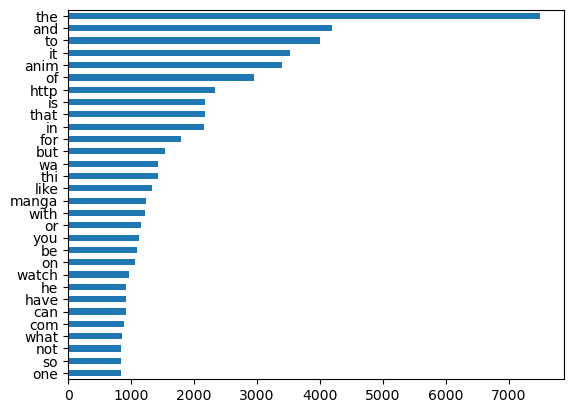

In [14]:
#Before I comment too much more, I am interested in exploring some of their common words:

current_train_words = pd.DataFrame(current_trial[:-1].fit_transform(X_train).todense(), #Very neat syntax I found to reference
                                   #just the vectorizer part of our grid search [thanks to making enough errors and actually
                                   #reading their messages].
                      columns = current_trial[:-1].get_feature_names_out())
current_train_words.sum().sort_values().tail(30).plot(kind="barh");

In [15]:
for i in range(5):
    print(current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]) #Shoutout once again to Dori from Stackoverflow re. getting the index out of a value counted type thing. 
    print(df[df['cleaned_post'].str.contains(current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i])]['subreddit'].value_counts(normalize=True))
    print('~'*26)
#Although the first four are all stop words, their inclination towards anime add up, especially as despite having the option
#to use English stop words, CV determined their presence was actually useful in identifying one class over the other.
#This is consistent with our theory of basically any words are more likely to denotate anime as just many more words
#are being used.

the
subreddit
1    0.608224
0    0.391776
Name: proportion, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~
and
subreddit
1    0.643784
0    0.356216
Name: proportion, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~
to
subreddit
1    0.605987
0    0.394013
Name: proportion, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~
it
subreddit
1    0.618218
0    0.381782
Name: proportion, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~
anim
subreddit
1    0.941046
0    0.058954
Name: proportion, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~


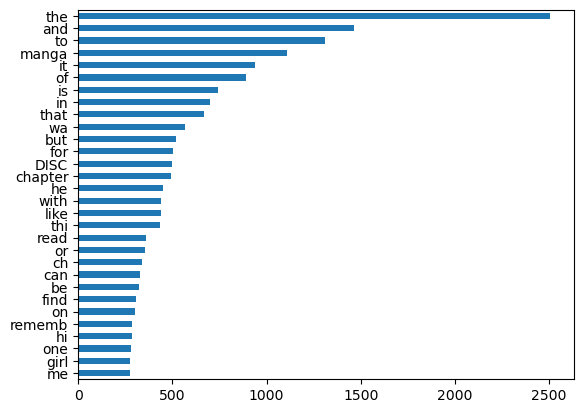

In [16]:
#Let's try to hone in on the words that predominate mangas [without considering mutual frequency in anime]:
current_train_words['subreddit'] = y_train.reset_index(drop=True)

#For manga, which is of greater interest to me considering that most of the 'posts' we just used their titles.
current_train_words[current_train_words['subreddit']==0].sum().sort_values().tail(30).plot(kind="barh");
#So, we see many overlaps. Off hand what stands out is manga, DISC, chapter, and read. Let's try something else though:

In [17]:
#Although their frequencies in manga appear above, let's see how many are actually in a majority of manga posts.
thresh, dict_of_word_proportions = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(400): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[0] - base[1] >= thresh:
            dict_of_word_proportions.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[0]
            })
    except:
        pass
print(len(dict_of_word_proportions))

3


In [18]:
dict_of_word_proportions  #So, it took 400 words to finally get a third word that is dominately in the manga camp.
#Note that 'manhwa' is a term for Korean manga, so arguably the same word as 'manga' for the sake of simplication.

[{'current_tier': 16, 'word': 'manga', 'm_count': 0.8631319358816276},
 {'current_tier': 62, 'word': 'chapter', 'm_count': 0.9798657718120806},
 {'current_tier': 333, 'word': 'manhwa', 'm_count': 0.9620253164556962}]

In [19]:
#Meanwhile, with anime:
thresh, dict_of_word_proportions = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(400): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[1] - base[0] >= thresh:
            dict_of_word_proportions.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[0]
            })
    except:
        pass
print(len(dict_of_word_proportions))
#And this is unsurprising given our observations on word counts.

220


## Transition: Fom 'SelfTexts' to Titles
### Logistic Regression Modeling

In [20]:
#Although our model earlier is clearly overfit, I have no interest in parameter tuning a model that already did so well, 
#nor even gauging other models' performances when I suspect and observe the following:

#The sheer discrepancy between the reality of most manga posts are being represented in this analysis by their titles.
#Hence, the the median and mean of anime being over 50 words greater than that of anime (see earlier).
#Perforce, any conclusions reached would be dubious at best for the company as it's not a direct comparison of WORDS used 
#by the two subreddits, but a difference in their culture. And, while that could be justified by then including tendencies 
#to post pictues and the like, it too greatly strays away from the company's request to focus on their words.
#Titles, however, would seem to be an appropriate comparison, not only in content (words) but they are of near identical
#mean and medium (earlier).

#Continuing. So, although we've yet to 'properly fit' even this model, I feel remarkably little justification for
#the sake of exploring NLP where even stop words are fit to be included on the basis of their ovewhelming predictive powe,
#Seemingly just on the basis that anime posts are 'actual posts' while the 'posts' from manga are mostly their titles.

#We'll repeat the entertaiing, at least for me, exercise of word frequency/category later on.

#So, I will now examine their titles and see if we can make an accurate distinction between the two of them:
#Recall that the average manga and anime posts were approximately 9 and 9.3 words in length.
X = df['cleaned_title']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 26, #Recall that I like this number
                                                    stratify=y)

In [21]:
#See below:
#So, our goal is to prune as many as such words as possible:
eng_stop_words = stopwords.words('english')
eng_stop_words = [re.sub("[^a-zA-Z]",'', eng_stop_words[i]) for i in range(len(eng_stop_words))]
eng_stop_words.append("I")
words_to_add = ['manga', 'anime', 'anim']
#We'll leave it at the main ones for now, as with our current proposal I can't justify removing wods that are not essentially
#just the identifyiers. Reminder that we are currently just analyzing titles.

#words_to_consider = ['episod', 'chapter', 'season', 'anim', 'ani', 'show', 'watch', 'read', 'myanimelist', 
#                     'anilist', 'crunchyrol', 'myanimelist net', 'rewatch', 'stream', 'ch']
#words_to_ponder = ['http', 'com', 'disc', 'link', 'www', 'redd', 'wa', 'net', 'reddit', 'reddit cmment', 
#                   'anidb', 'png', 'github']
#Consiring also adding 'ani' which was likely a shortened version of 'anime', but we'll leave it for now:

In [22]:
complete_stop = eng_stop_words.copy() #Still odd that we have to use .copy() as otherwise the two would mimmic each other.
for i in range(len(words_to_add)):
    complete_stop.append(words_to_add[i])
#for i in range(len(words_to_consider)):
#    complete_stop.append(words_to_consider[i])
#for i in range(len(words_to_ponder)):
#    complete_stop.append(words_to_ponder[i])
print(len(complete_stop), len(eng_stop_words))

183 180


In [23]:
#Once again, we'll start with CVec and LogReg. We'll go with the previous trial parameters from the pevious attempt.
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('lr', LogisticRegression(max_iter=2500))
])
pipe_params = {'cvec__min_df' : [.01],
               'cvec__max_df' : [.975],
               'cvec__ngram_range' : [(1, 1), (1,2)],
               'cvec__max_features' : [1000, 1025, 975],
               'cvec__stop_words' : ['english'],
               'lr__penalty' : ['l2'],
               'lr__C' : [1.0, .95, .9]
               
              }
gs_lrcv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [24]:
gs_lrcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=2500))]),
             param_grid={'cvec__max_df': [0.975],
                         'cvec__max_features': [1000, 1025, 975],
                         'cvec__min_df': [0.01],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'lr__C': [1.0, 0.95, 0.9], 'lr__penalty': ['l2']})

In [25]:
print(gs_lrcv.score(X_train, y_train), gs_lrcv.score(X_test, y_test))
print(gs_lrcv.best_score_)
print(gs_lrcv.best_params_)

0.9258547829427584 0.9062980030721967
0.9189428613612873
{'cvec__max_df': 0.975, 'cvec__max_features': 1000, 'cvec__min_df': 0.01, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'lr__C': 1.0, 'lr__penalty': 'l2'}


#### Disclosure:
Many of the following numbers, whether scoring metrics or parameter tunings were generated via testing with the original
two dataframes of 1k titles posts each, so by the time data was re-run with the current 'full' data parameter tunings were
already close to their 'final' values. So, if the reader is interested in trying to emulate my processs then please do not
be surprised if diffrent numbers are obtained. However, the final version was obviously ran with the 'full' data, as the active code clearly indicates.

In [26]:
# #Now with this I am pleased with! Althoguh already having a decently high train and test split, the room for parameter tuning
# #is suddenly meaningful, and of course still relevant to the problem statement and purpose of this project, to tune.
# #Ie, despite the much shorter length inherent in titles, our model is already able to be 'accurate' in distinguishing
# #between the two of them. #Anyways, onto our regular analysis:

# #Hmm, we'll lower allowed words and bring into the fold the custom stopwords [added above the pipeline]

# 0.9258547829427584 0.9062980030721967
# 0.9189428613612873
# {'cvec__max_df': 0.975, 'cvec__max_features': 1000, 'cvec__min_df': 0.01, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
# pipe_params = {'cvec__min_df' : [.01],
#                'cvec__max_df' : [.975],
#                'cvec__ngram_range' : [(1, 1), (1,2), (1, 3)],
#                'cvec__max_features' : [1000, 1050, 950],
#                'cvec__stop_words' : ['english', None]
#               }

#Despite more tuning, we haven't been able to change from our previous ones. So, unless I would try to focus on words that
#are neutral in their prevalence of one title or another. So, we're left with a decent bit of overfitting.

In [27]:
#Anyways, it's time for LR to meet Tiffany:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('lr', LogisticRegression(max_iter=3000))
])
pipe_params = {'tvec__min_df' : [.0],
               'tvec__max_df' : [.975],
               'tvec__ngram_range' : [(1,1), (1,2)],
               'tvec__max_features' : [1275, 1300, 1325],
               'tvec__stop_words' : ['english', None]
               }
gs_lrtv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [28]:
gs_lrtv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=3000))]),
             param_grid={'tvec__max_df': [0.975],
                         'tvec__max_features': [1275, 1300, 1325],
                         'tvec__min_df': [0.0],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english', None]})

In [29]:
print(gs_lrtv.score(X_train, y_train), gs_lrtv.score(X_test, y_test))
print(gs_lrtv.best_score_)
print(gs_lrtv.best_params_)

0.9708029197080292 0.9416282642089093
0.9381492691569466
{'tvec__max_df': 0.975, 'tvec__max_features': 1325, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


In [30]:
# #First:
# 0.9761813292354975 0.9062980030721967
# 0.9381536985087848
# {'tvec__max_df': 0.975, 'tvec__max_features': 1300, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
# pipe_params = {'tvec__min_df' : [.0, .025],
#                'tvec__max_df' : [.975, .95, .925],
#                'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
#                'tvec__max_features' : [1200, 1300, 1400],
#                'tvec__stop_words' : ['english', None, complete_stop]
#               }

# #Despite our tinkerings, we weren't able to greatly deviate from the above. Of note is the following:
# #Tiffany, with our data preffered, more features and not using stop words.

# #And of course, the juicy part: accuracy. While still being overfit, Tiffany managed to widen that discrepancy
# #to a spread of .26; CVec was slightly under .2. However, her "baseline" accuracy, per test, is much higher than even
# #the train of cvec. So, she might win this battle of selection.

### Multinomial Naive Bayes

In [31]:
#Now let us move onto MNB. Starting with cvec:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('mnb', MultinomialNB())
])
pipe_params = {'cvec__min_df' : [.0],
               'cvec__max_df' : [.975],
               'cvec__ngram_range' : [(1,2)],
               'cvec__max_features' : [2740, 2745, 2735],
               'cvec__stop_words' : ['english'],
               'mnb__alpha': [.95]
              }
gs_mnbcv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [32]:
gs_mnbcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002A7181BB1A0>)),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.975],
                         'cvec__max_features': [2740, 2745, 2735],
                         'cvec__min_df': [0.0], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english'],
                         'mnb__alpha': [0.95]})

In [33]:
print(gs_mnbcv.score(X_train, y_train), gs_mnbcv.score(X_test, y_test))
print(gs_mnbcv.best_score_)
print(gs_mnbcv.best_params_)

#Wow, we now have an even smaller, less than .01, accursnvu discrepency between our train and test. Furthermore, we now have
#a slightly higher test score! So, this model is definitely 'winning' at the moment.

0.9611986169804072 0.9523809523809523
0.936614498745017
{'cvec__max_df': 0.975, 'cvec__max_features': 2740, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'mnb__alpha': 0.95}


In [34]:
# #Re. the first iteration, and reminde that the baseline 'guesses' were based upon prior iterations:
# 0.9608144448713023 0.9523809523809523
# 0.936614498745017
# {'cvec__max_df': 0.975, 'cvec__max_features': 2750, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'mnb__alpha': 0.95}
# pipe_params = {'cvec__min_df' : [.0],
#                'cvec__max_df' : [.975],
#                'cvec__ngram_range' : [(1,1), (1,2)],
#                'cvec__max_features' : [2700, 2750, 2800],
#                'cvec__stop_words' : [None, 'english'],
#                'mnb__alpha': [.95, .925, .975]
#               }

#Of special note, besides the similarily high train and test accuracies, is as follows: We now have a model that fits best with
#almost double the features of the previous ones. And, likely that is a result of it choosing a 1,2 ngram range (another
#unique feature of this model). Also note that we are still retaining the abscence of English stopwords.

In [35]:
#Let's go to Tiffany now:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('mnb', MultinomialNB())
])
pipe_params = {'tvec__min_df' : [.05],
               'tvec__max_df' : [.975],
               'tvec__ngram_range' : [(1,1), (1,2)],
               'tvec__max_features' : [1000, 1050, 950],
               'tvec__stop_words' : [None],
               'mnb__alpha' : [1]
              }
gs_mnbtv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [36]:
gs_mnbtv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002A7181BB920>)),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': [1], 'tvec__max_df': [0.975],
                         'tvec__max_features': [1000, 1050, 950],
                         'tvec__min_df': [0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None]})

In [37]:
print(gs_mnbtv.score(X_train, y_train), gs_mnbtv.score(X_test, y_test)) #Yeah, that didn't do anything.
print(gs_mnbtv.best_score_)
print(gs_mnbtv.best_params_)
#In short, re. gs_mnbtv's selection: Despite having a small difference between train and test, honestly I think the smallest
#from mental math, the much lower prediction rates compared to the others, especially when we used CVec with MNB, that
#this will not be selected.

0.866692278140607 0.858678955453149
0.8640152074413111
{'mnb__alpha': 1, 'tvec__max_df': 0.975, 'tvec__max_features': 1000, 'tvec__min_df': 0.05, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [38]:
# # #First up we have the following:

# 0.866692278140607 0.858678955453149
# 0.8640152074413111
# {'mnb__alpha': 1, 'tvec__max_df': 0.975, 'tvec__max_features': 1000, 'tvec__min_df': 0.05, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
# pipe_params = {'tvec__min_df' : [.05],
#                'tvec__max_df' : [.975, .95],
#                'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
#                'tvec__max_features' : [1000, 1500, 2000],
#                'tvec__stop_words' : [None, 'english'],
#                'mnb__alpha' : [1, .95, .9]
#               }

### Support Vector Classification

In [39]:
#Hmm, let's look at SVC now, starting with CVec:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('svc', SVC())
])
pipe_params = {'cvec__min_df' : [.0],
               'cvec__max_df' : [1.0],
               'cvec__ngram_range' : [(1,3)],
               'cvec__max_features' : [2540, 2520],
               'cvec__stop_words' : ['english'],
               'svc__kernel': ['linear'],
               'svc__C': [.94, .942]
              }
gs_svccvec = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [40]:
gs_svccvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002A717D405E0>)),
                                       ('svc', SVC())]),
             param_grid={'cvec__max_df': [1.0],
                         'cvec__max_features': [2540, 2520],
                         'cvec__min_df': [0.0], 'cvec__ngram_range': [(1, 3)],
                         'cvec__stop_words': ['english'],
                         'svc__C': [0.94, 0.942], 'svc__kernel': ['linear']})

In [41]:
print(gs_svccvec.score(X_train, y_train), gs_svccvec.score(X_test, y_test))
print(gs_svccvec.best_score_)
print(gs_svccvec.best_params_)
#So, of note is the higher train score, indicating the trend we've always seen thus far which is overfitting, yet
#were unable to bring it down. SVC with CVEC still had a 'high' test compared with what we've seen, however given the
#great discrepancy...

0.9911640414905878 0.9339477726574501
0.9323903735420049
{'cvec__max_df': 1.0, 'cvec__max_features': 2540, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'svc__C': 0.94, 'svc__kernel': 'linear'}


In [42]:
# #Second iteration, and wow that took a while (and given the length I'm not redoing what I used for the first one):

# 0.9911640414905878 0.9339477726574501
# 0.9323903735420049
# {'cvec__max_df': 1.0, 'cvec__max_features': 2540, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'svc__C': 0.94, 'svc__kernel': 'linear'}
# pipe_params = {'cvec__min_df' : [.0],
#                'cvec__max_df' : [1.0],
#                'cvec__ngram_range' : [(1,3)],
#                'cvec__max_features' : [2540, 2500],
#                'cvec__stop_words' : ['english'],
#                'svc__kernel': ['linear'],
#                'svc__C': [.94, .945]
#               }

#So, we once again have a model with a large amount of desirable featues. We now see ngram of 1,3 being selected as well.

In [43]:
#With Tiffany now:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('svc', SVC())
])
pipe_params = {'tvec__min_df' : [.0],
               'tvec__max_df' : [1.0],
               'tvec__ngram_range' : [(1,2), (1,3)],
               'tvec__max_features' : [2500, 2525, 2475],
               'tvec__stop_words' : ['english'],
               'svc__kernel': ['linear'],
               'svc__C': [.95]
              }
gs_svctvec = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [44]:
gs_svctvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002A717D41760>)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.95], 'svc__kernel': ['linear'],
                         'tvec__max_df': [1.0],
                         'tvec__max_features': [2500, 2525, 2475],
                         'tvec__min_df': [0.0],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [45]:
print(gs_svctvec.score(X_train, y_train), gs_svctvec.score(X_test, y_test))
print(gs_svctvec.best_score_)
print(gs_svctvec.best_params_)
#A closer range and still overall quite accurate, however still a greater spread than I'm comfortable with.

0.9796388782174414 0.9324116743471582
0.9366130222944042
{'svc__C': 0.95, 'svc__kernel': 'linear', 'tvec__max_df': 1.0, 'tvec__max_features': 2500, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [46]:
# #We'll leave it there for now, and unfortunately I forgot to copy the initial parameters we tested... And, this one
# #took even  longer to fit than with Cvec so definitely aren't doing it again...

# 0.9796388782174414 0.9324116743471582
# 0.9366130222944042
# {'svc__C': 0.95, 'svc__kernel': 'linear', 'tvec__max_df': 1.0, 'tvec__max_features': 2500, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
# pipe_params = {'tvec__min_df' : [.0],
#                'tvec__max_df' : [1.0],
#                'tvec__ngram_range' : [(1,2), (1,3)],
#                'tvec__max_features' : [2400, 2500, 2600],
#                'tvec__stop_words' : ['english'],
#                'svc__kernel': ['linear'],
#                'svc__C': [.95]
#               }

#Another model where we have a large amount of features. However, unlike with cvec, Tiffany preferred 1-3 gram. 

### K Nearest Neighbors

In [47]:
#Hmm,next up let's go for KNN, starting with CVec:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('knn', KNeighborsClassifier())
])
pipe_params = {'cvec__min_df' : [.0],
               'cvec__max_df' : [1.0],
               'cvec__ngram_range' : [(1,1), (1,2)],
               'cvec__max_features' : [1850, 1900, 1950],
               'cvec__stop_words' : [None, 'english'],
               'knn__n_neighbors': [9],
               'knn__p': [1],
               'knn__weights': ['distance']
              }
gs_cvecknn = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [48]:
gs_cvecknn.fit(X_train, y_train) #Once again, another model that took quite a long time to fit, hence given results
#my disinclinement to try more tuning.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002A717D422A0>)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [1.0],
                         'cvec__max_features': [1850, 1900, 1950],
                         'cvec__min_df': [0.0],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'knn__n_neighbors': [9], 'knn__p': [1],
                         'knn__weights': ['distance']})

In [49]:
print(gs_cvecknn.score(X_train, y_train), gs_cvecknn.score(X_test, y_test))
print(gs_cvecknn.best_score_)
print(gs_cvecknn.best_params_)

#Once again, continuing the trend of lots of overfitting, yet overall accuracy. We continue.

0.9953899346907414 0.9032258064516129
0.9085656282297357
{'cvec__max_df': 1.0, 'cvec__max_features': 1900, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}


In [50]:
#First try:

# 0.9993734335839599 0.7675
# 0.7575195924764891
# {'cvec__max_df': 1.0, 'cvec__max_features': 2000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'knn__n_neighbors': 9, 'knn__p': 2, 'knn__weights': 'distance'}

#Second try, and we'll do our analysis now:
#0.9981203007518797 0.77
#0.7725764106583073
#{'cvec__max_df': 1.0, 'cvec__max_features': 1750, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'knn__n_neighbors': 9, 'knn__p': 2, 'knn__weights': 'distance'}

#So, bottom line notice the incredibly high train, yet it fails so much, at least relativly to the other models with 
#test, being a meager 77%. Note that I still have much to tune, noticing quite a big shift in featues, yet I have no
#motivation to at the present with given changes, especially when increasing potential neighbors from 9 to 11 and 13 made
#no difference. Albeit perhaps even bigger numbers might make a difference, but regardless we continue.

In [51]:
#Now it's Tiffany's turn:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('knn', KNeighborsClassifier())
])
pipe_params = {'tvec__min_df' : [.0],
               'tvec__max_df' : [1.0],
               'tvec__ngram_range' : [(1,1), (1,2)],
               'tvec__max_features' : [1975, 2000, 2025],
               'tvec__stop_words' : ['english'],
               'knn__n_neighbors': [13, 15],
               'knn__p': [1],
               'knn__weights': ['distance']
              }
gs_tvecknn = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [52]:
gs_tvecknn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002A7180FC0E0>)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [13, 15], 'knn__p': [1],
                         'knn__weights': ['distance'], 'tvec__max_df': [1.0],
                         'tvec__max_features': [1975, 2000, 2025],
                         'tvec__min_df': [0.0],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']})

In [53]:
print(gs_tvecknn.score(X_train, y_train), gs_tvecknn.score(X_test, y_test))
print(gs_tvecknn.best_score_)
print(gs_tvecknn.best_params_)

#Once again, overall well, but a high discrepency of between train and test peersists.

0.996926623127161 0.9216589861751152
0.8951048279935035
{'knn__n_neighbors': 13, 'knn__p': 1, 'knn__weights': 'distance', 'tvec__max_df': 1.0, 'tvec__max_features': 2000, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


In [54]:
# #First time we're actually running KNN with Tiffany:
# 0.996926623127161 0.9062980030721967
# 0.8831906097741031
# {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance', 'tvec__max_df': 1.0, 'tvec__max_features': 2000, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
# pipe_params = {'tvec__min_df' : [.0],
#                'tvec__max_df' : [1.0],
#                'tvec__ngram_range' : [(1,1), (1,2)],
#                'tvec__max_features' : [1750, 2000],
#                'tvec__stop_words' : [None, 'english'],
#                'knn__n_neighbors': [9, 11],
#                'knn__p': [1],
#                'knn__weights': ['distance']
#               }

In [55]:
#Theoretically, I should do forests and bagging, but we have enough models. As the client... wants at least a 'first draft'
#ASAP.

### Final Decision

In [56]:
#I'd like to next compare a bit more in depth four of the most desirable models to me:

#So, at the present our best model, per the combination of having the smallest discrepencies between train and test
#and a high test score is our MNB with CVec.
#So, let us regurgitate it and save it for later:
best_model = gs_mnbcv.best_estimator_
best_model.fit(X_train,y_train)
best_model.score(X_train, y_train), best_model.score(X_test, y_test)

#I would, however, like to say a number of downfalls associated with this: Inherently NB is contradictory to what
#a language is - a series of dependent words to give rise to a more abstract concept - a sentence. However, given its
#bottom-line empirical accuracy this is not so much of an issue. Similarly, another issue could be a potential lack of data,
#then awarding a lot lower probabilities to words than what 'should occur'; however we seemed to have gathered enough data 
#to avoid that pitfall.

(0.9611986169804072, 0.9523809523809523)

In [57]:
bm2 = gs_lrtv.best_estimator_
bm2.fit(X_train,y_train)
bm2.score(X_train, y_train), bm2.score(X_test, y_test)
#I'm going lrs's Tiffany for th second best model, given it's excell performance overall. However, because it's test
#accuracy was not as high as mnb's cvec, sa well as having a much wider gap, I'm ranking it at number 2.

(0.9708029197080292, 0.9416282642089093)

In [58]:
bm3 = gs_lrcv.best_estimator_
bm3.fit(X_train,y_train)
bm3.score(X_train, y_train), bm3.score(X_test, y_test)
#Although having a lower accuracy discrepency, its overall lower accuracy makes it not as desirable.

(0.9258547829427584, 0.9062980030721967)

In [59]:
bm4 = gs_svctvec.best_estimator_
bm4.fit(X_train,y_train)
bm4.score(X_train, y_train), bm4.score(X_test, y_test)
#And finally, interestingly, I am ranking SVC at number 4. Although higher in accuracy than the previous one, its greater
#discrepency between train and test makes it unappealing. Futhermore,it's an overall more difficult model to explain
#to our fair clients.

(0.9796388782174414, 0.9324116743471582)

In [61]:
#Prediction time
preds_1 = best_model.predict(X_test)
preds_2 = bm2.predict(X_test)
preds_3 = bm3.predict(X_test)
preds_4 = bm4.predict(X_test)

tn1, fp1, fn1, tp1 = confusion_matrix(y_test, preds_1).ravel() #We'll have the default be the plain ones.
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds_2).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds_3).ravel()
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, preds_4).ravel()

In [62]:
#Eh, should probably might a dictionary of these guys, but eh:
print(f"The {1} model's accuracy is: {(tp1+tn1)/(tp1+tn1+fp1+fn1)}.")
print(f"The {2} model's accuracy is: {(tp2+tn2)/(tp2+tn2+fp2+fn2)}.")
print(f"The {3} model's accuracy is: {(tp3+tn3)/(tp3+tn3+fp3+fn3)}.")
print(f"The {4} model's accuracy is: {(tp4+tn4)/(tp4+tn4+fp4+fn4)}.")

The 1 model's accuracy is: 0.9523809523809523.
The 2 model's accuracy is: 0.9416282642089093.
The 3 model's accuracy is: 0.9062980030721967.
The 4 model's accuracy is: 0.9324116743471582.


In [63]:
#Now when it comes to precision:
print(f"The {1} model's precision is: {(tp1)/(tp1+fp1)}.")
print(f"The {2} model's precision is: {(tp2)/(tp2+fp2)}.")
print(f"The {3} model's precision is: {(tp3)/(tp3+fp3)}.")
print(f"The {4} model's precision is: {(tp4)/(tp4+fp4)}.")

The 1 model's precision is: 0.9429429429429429.
The 2 model's precision is: 0.9285714285714286.
The 3 model's precision is: 0.8753541076487252.
The 4 model's precision is: 0.9171597633136095.


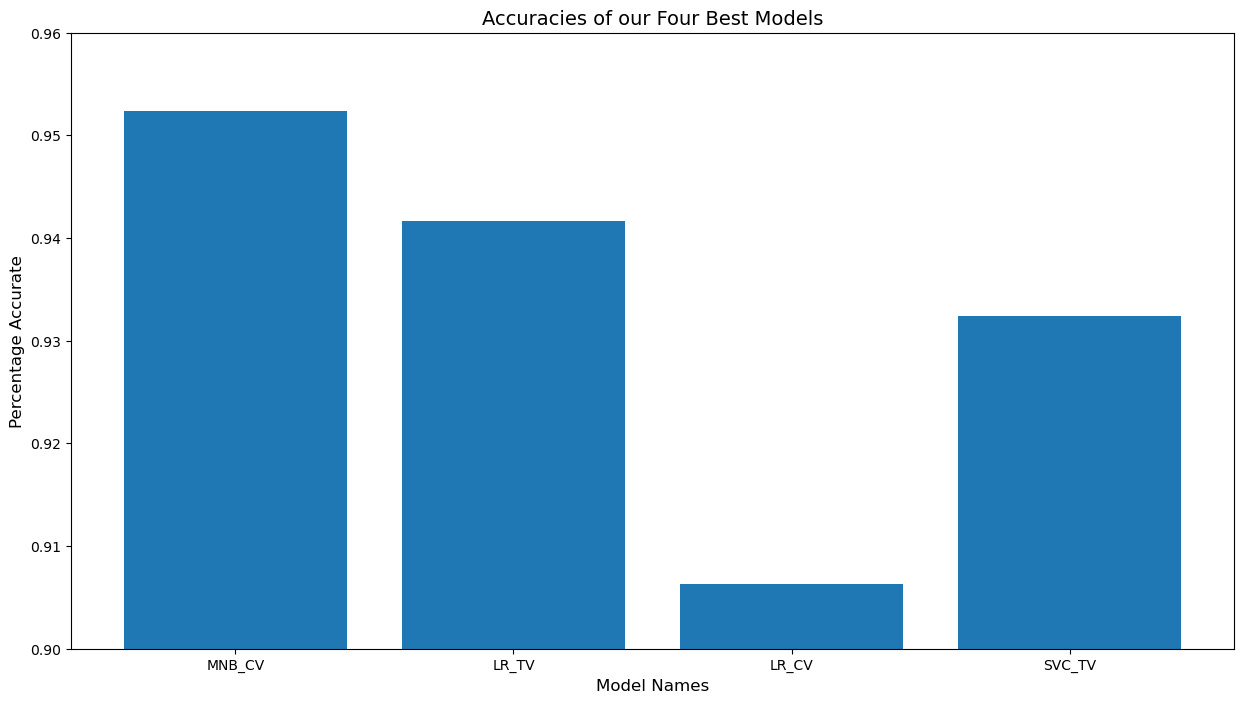

In [64]:
cats = ['MNB_CV', 'LR_TV', 'LR_CV', 'SVC_TV']
values = [(tp1+tn1)/(tp1+tn1+fp1+fn1),(tp2+tn2)/(tp2+tn2+fp2+fn2),(tp3+tn3)/(tp3+tn3+fp3+fn3),(tp4+tn4)/(tp4+tn4+fp4+fn4)]

plt.figure(figsize = (15, 8))
plt.bar(cats, values)
plt.title("Accuracies of our Four Best Models", fontsize = 14)
plt.xlabel("Model Names", fontsize = 12)
#plt.yticks(np.arange(.8, 1.0, .02))
plt.subplot().set_ylim([.9, .96]) #Thanks to Stack Overflow's Baron Legendre for pointout this syntax to me. Unfortunately
#it seems that I can only reference it via .subplot() though; oh, appaently via matplotlib.axes.Axes.set_ylim I could also
#do it. However,I'd rather not have to import just that at the moment...
plt.ylabel("Percentage Accurate", fontsize = 12);

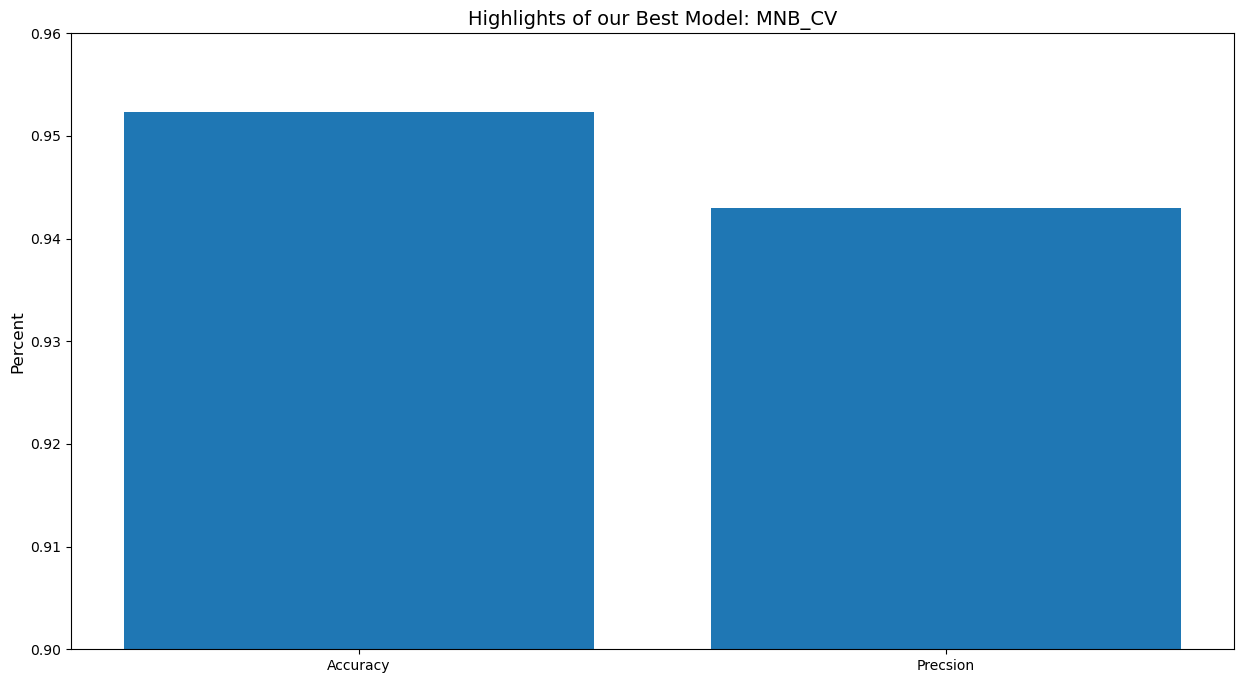

In [65]:
#Now let's focus graphing our best model's, mnb_cv's, accuracies and precision:
cats = ['Accuracy', 'Precsion']
values = [(tp1+tn1)/(tp1+tn1+fp1+fn1),(tp1)/(tp1+fp1)]

plt.figure(figsize = (15, 8))
plt.bar(cats, values)
plt.title("Highlights of our Best Model: MNB_CV", fontsize = 14)
#plt.yticks(np.arange(.8, 1.0, .02))
plt.subplot().set_ylim([.9, .96])
plt.ylabel("Percent", fontsize = 12);

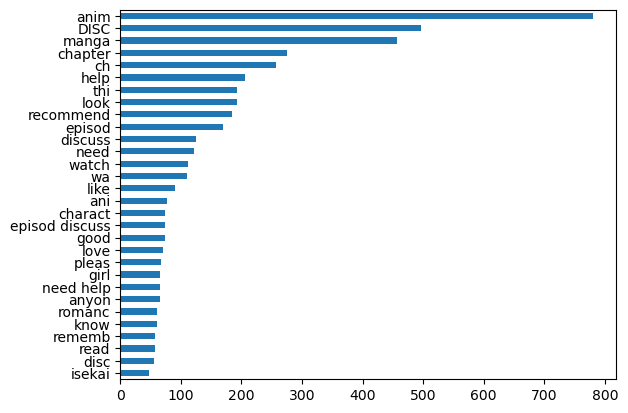

In [66]:
#And now that we've finally selected our final model, MNB's cv, let us go back to our 'original' word frequency exercise:

X_train_best = best_model[0].fit_transform(X_train).todense()

X_train_words = pd.DataFrame(X_train_best,
                            columns=best_model[0].get_feature_names_out())

X_train_words.sum().sort_values().tail(30).plot(kind="barh");

In [67]:
#See earlier for relevant assumptions.

#Manga:

thresh, dict_of_word_proportions_m = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(30): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = X_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[0] - base[1] >= thresh:
            dict_of_word_proportions_m.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[0]
            })
    except:
        pass
print(len(dict_of_word_proportions_m))

4


In [68]:
dict_of_word_proportions_m #And, none of these are surprising in of themselves. Let's consider the next grouping though
#before we revisit this:

[{'current_tier': 2, 'word': 'manga', 'm_count': 0.9434628975265018},
 {'current_tier': 3, 'word': 'chapter', 'm_count': 0.9971264367816092},
 {'current_tier': 21, 'word': 'girl', 'm_count': 0.7373737373737373},
 {'current_tier': 26, 'word': 'read', 'm_count': 0.8888888888888888}]

In [69]:
#Anime:

thresh, dict_of_word_proportions = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(30): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = X_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[1] - base[0] >= thresh:
            dict_of_word_proportions.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[1]
            })
    except:
        pass
print(len(dict_of_word_proportions))

9


In [70]:
dict_of_word_proportions
#So, the following words, well technically tokens, are unsurprising:'anim', 'episod'. 'watch', 'ani' [assuming it's
#short/misspelling of anime], and 'season', as all of those directly relate to anime. However, the rest are surprising
#as they would sem to be generic. Now, the 2:1 ratio I assumed by default is arguably not significant enough to reach
#definitive conclusions about the cultures surrounding each subreddit. However, the following would sem to be indications
#of differences in their culture. Recall that we are basing this off of approximately a week's worth of data.
    #Note, in retrospect 'ani' was originally 'any', so it remains peculiar without understanding more of the subreddits culture
    #as to why there iss uch a discrepency.

[{'current_tier': 0, 'word': 'anim', 'm_count': 0.979765708200213},
 {'current_tier': 8, 'word': 'recommend', 'm_count': 0.6909871244635193},
 {'current_tier': 9, 'word': 'episod', 'm_count': 0.9211822660098522},
 {'current_tier': 12, 'word': 'watch', 'm_count': 0.9896373056994818},
 {'current_tier': 15, 'word': 'ani', 'm_count': 0.9278656126482213},
 {'current_tier': 16, 'word': 'charact', 'm_count': 0.813953488372093},
 {'current_tier': 27, 'word': 'rememb', 'm_count': 0.6986301369863014},
 {'current_tier': 28, 'word': 'disc', 'm_count': 0.6885964912280702},
 {'current_tier': 29, 'word': 'season', 'm_count': 0.9074074074074074}]

In [71]:
#Unsure if there was a more elegant way to do this, but eh:
bar_colors, bar_labels = [], []

first = True
for i in range(30):
    bar_colors.append('tab:blue')
    if first == False:
        bar_labels.append('_neutral')
    else:
        bar_labels.append('neutral')
        first = False
first = True
for i in range(len(dict_of_word_proportions_m)):
    bar_colors[dict_of_word_proportions_m[i]['current_tier']] = 'tab:grey'
    if first == False:
        bar_labels[dict_of_word_proportions_m[i]['current_tier']]= '_manga'
    else:
        bar_labels[dict_of_word_proportions_m[i]['current_tier']] = 'manga'
        first = False
first = True
for i in range(len(dict_of_word_proportions)):
    bar_colors[dict_of_word_proportions[i]['current_tier']] = 'tab:orange'
    if first == False:
        bar_labels[dict_of_word_proportions[i]['current_tier']] = '_anime'
    else:
        bar_labels[dict_of_word_proportions[i]['current_tier']] = 'anime'
        first = False
#Gah, not at all elegant, but to tweak this:
bar_labels[1] = 'neutral'



In [72]:
bar_colors[:2]

['tab:orange', 'tab:blue']

In [73]:
bar_labels[:3]

['anime', 'neutral', 'manga']

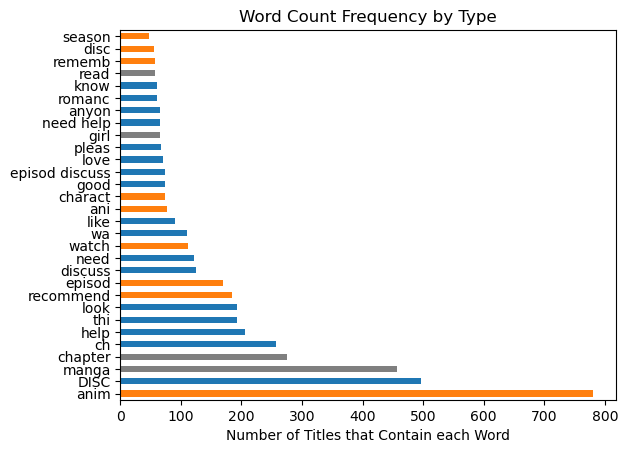

In [74]:
#Note the difference in arrangement of the bar graphs... per my current knowledge of using bar colors I was unable
#to correctly allign them for whatever reason with the previous format (even a bar_colors[::-1] was of no avail.
X_train_words.sum().sort_values(ascending=False).head(30).plot(kind="barh", color=bar_colors)
plt.title("Word Count Frequency by Type")
plt.xlabel("Number of Titles that Contain each Word");

#Sigh, I was unable to get the legend to work. We'll just go with this for now...

#Note that 'episod discuss' is not marked.... likely because of the limitations I did in checking if a word is there -
#as that is a 2 gram that could have easily had a stop word in between... I NEED to figure out a wayt o scour this.

#plt.legend(title='Majority');

In [ ]:
#Now let's look at a few samples where we lacked precision, ie our model thought it was an anime...

In [75]:
final = {'test':y_test,'pred':preds_1}
comp = pd.DataFrame(final)
comp[(comp['test'] != comp['pred']) & (comp['pred'] == 1)][:10]

,test,pred
1065,0,1
802,0,1
549,0,1
556,0,1
524,0,1
1076,0,1
991,0,1
119,0,1
1063,0,1
993,0,1


In [76]:
df.iloc[1065]['cleaned_title'] #This one is particularly interesting and reasonable to misinterpret as Frieren Beyond
#Journey's end is curently [1/28/24] the #1 ANIME on Myanimelist.net at the moment. So, likely the model put more
#of an association of seeing Frieren in anime.
#Should really confirm the frequency, but considering timing...

'recommend s that are similar to frieren beyond journey s end'

In [77]:
df.iloc[802]['cleaned_title'] #Yeah, not so sure what to say about this one...likely mangaupd was not so common. Note
#for future iteratons: Try to somehow see if we could do custom stems, or at least fish around for things like this.
#I've never heard of mangaupd, but the context seems clear to be some [illegal likely] website to read manga for free.

'did someth happen to mangaupd'

In [78]:
df.iloc[549]['cleaned_title'] #Vague and nothing to fault it for.

'true good romanc'

In [79]:
df.iloc[556]['cleaned_title'] #ALso vague and nothing to fault it for.

'what are some good new releas'

In [80]:
df.iloc[524]['cleaned_title'] #Once again, vague and nothing to fault it for

'question look for specif romanc stori'

In [81]:
#I'll now fish around until I find something else of interest
df.iloc[1076]['cleaned_title'] #Yeah, from a NLP perspective I could see this one being a bit difficult. The emphasis
#is on it currently being a bit hit, which would imply it's 

'what newish non WSJ manga without an anim do you think will be a big hit'

In [82]:
df.iloc[119]['cleaned_title']  #This one I find quite interesting. From a human perspective the emphasis is clearly seeking
#out manga, yet overwhelming tokens such as 'anim' and 'watch' are present to confuse our model...

'can anyon recommend a good adventur manga base on anim I ve watch'